## Часть -1. Описание

Проект - географическая игра, состоящая из нескольких небольших тестов. Может понравится тем, кто интересуется географией. Или тем, кому стало очень скучно. 

## Часть 0. Подготовка данных

Начнём с того, что загрузим основные данные про страны. Возьмём мы их [отсюда](https://github.com/mledoze/countries). Про то, какая для каждой страны хранится информация, можно подробно почитать в README (ссылка выше). Нам же пригодится только следующие данные:

1. Название страны
2. ISO2 и ISO3 коды страны ("Россия", "РФ", "Российская Федерация" - разные названия одной и той же страны. А мы хотим иметь универсальный код для обозначения страны. Для этого используются [ISO2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2) и [ISO3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) коды)
3. Столица страны
4. Регион и субрегион, к которым страна принадлежит
5. Долгота и широта
6. Страны-соседи
7. Площадь страны

Установим всё необходимое:

In [ ]:
!pip install -q geopandas
!pip install -q mapclassify
!pip install -q scrapy
!pip install -q levenshtein

In [ ]:
import pandas as pd
import requests


countries_data_raw = requests.get('https://raw.githubusercontent.com/mledoze/countries/master/countries.json').json()
countries_data = pd.DataFrame(columns={
        'country_name': [],
        'iso2': [],
        'iso3': [],
        'capital_name': [],
        'region': [],
        'subregion': [],
        'latitude': [],
        'longitude': [],
        'borders': [],
        'area': [],
        'flag': [],
})

for country_info in countries_data_raw:
    # оставим только признанные государства
    if not country_info['independent']:
        continue

    row = [
        country_info['name']['common'],
        country_info['cca2'],
        country_info['cca3'],
        # есть две записи, в котрых несколько столиц: это Южная Африка и Карибские Нидерланды
        # для них в целях простоты будем оставлять только одну
        country_info['capital'][0],
        country_info['region'],
        country_info['subregion'],
        country_info['latlng'][0],
        country_info['latlng'][1],
        country_info['borders'],
        country_info['area'],
        country_info['flag']
    ]

    countries_data.loc[len(countries_data)] = row

Богу данных нужно больше данных, поэтому добавим ещё следующую информацию:

1. Координаты столицы страны
2. Население страны
3. Очертания страны

Начнём с первых двух. Информацию возьмём со следующих сайтов: [координаты](http://techslides.com/list-of-countries-and-capitals), [население](https://countrycode.org/). Получать её будем с помощью `scrapy`.

In [ ]:
def dump_cell(filename='crawler.py'):
    with open(filename, mode='w') as f:
        f.write(_i)

In [ ]:
import re
import scrapy

class TablesSpider(scrapy.Spider):
    name = 'table_spider'

    def start_requests(self):
        urls = [
            'https://countrycode.org/',
            'http://techslides.com/list-of-countries-and-capitals',
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse_cell_value(self, text):
        if text is None:
            return None
        processed_text = re.sub(',', '', text)
        # здесь мы проверяем, является ли `processed_text` числом
        # если да, то переводим его во float, иначе возвращаем string
        if re.fullmatch('-?([0-9]*[.])?[0-9]+', processed_text):
            return float(processed_text)
        return processed_text

    def parse(self, response):
        table = response.xpath('//table')[0]
        table_data = []

        rows = table.xpath('.//tr')
        for row in rows:
            row_data = []
            cells_values = row.xpath('.//td')
            for cell_value in cells_values:
                cell_text = cell_value.xpath('.//text()').get()
                row_data.append(self.parse_cell_value(cell_text))
            table_data.append(row_data)
        
        if 'countrycode' in response.url:
            yield {'population_data': table_data}
        else:
            yield {'capitals_data': table_data}

In [ ]:
dump_cell()

In [ ]:
!scrapy runspider --nolog crawler.py -O crawled_tables.json

/usr/local/lib/python3.10/dist-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting for information on how to handle this deprecation.
  return cls(crawler)


Получили файл `crawled_tables.json`, в котором лежат две таблицы. Давайте преобразуем их в датафреймы.

In [ ]:
import json

with open('crawled_tables.json') as f:
    crawled_data = json.load(f)

capitals_data_raw = crawled_data[0]['capitals_data'][1:]
capitals_data = pd.DataFrame(capitals_data_raw, columns={
    'country_name': [],
    'capital_name': [],
    'capital_latitude': [],
    'capital_longitude': [],
    'iso2': [],
    'continent': []
})

population_data_raw = crawled_data[1]['population_data'][1:]
population_data = pd.DataFrame(population_data_raw, columns={
    'country_name': [],
    'country_code': [],
    'iso_codes': [],
    'population': [],
    'area': [],
    'gdp': [],
})
# в таблице с населением нет отедльной колонки для ISO2 или ISO3 кода
# поэтому добавим её отдельно
population_data['iso2'] = population_data['iso_codes'].apply(lambda row: row.split(' / ')[0])

Почему-то в таблице со столицами континентальная часть Северной Америки помечена как "Центральная Америка".

In [ ]:
capitals_data[capitals_data['continent'] == 'Central America']

country_name     capital_name  capital_latitude  \
22                             Belize         Belmopan         17.250000   
38                             Canada           Ottawa         45.416667   
50                         Costa Rica         San Jose          9.933333   
64                        El Salvador     San Salvador         13.700000   
83                          Greenland             Nuuk         64.183333   
86                          Guatemala   Guatemala City         14.616667   
93                           Honduras      Tegucigalpa         14.100000   
135                            Mexico      Mexico City         19.433333   
150                         Nicaragua          Managua         12.133333   
163                            Panama      Panama City          8.966667   
182         Saint Pierre and Miquelon     Saint-Pierre         46.766667   
183  Saint Vincent and the Grenadines        Kingstown         13.133333   
231                     United States  Washington D.C.         38.883333   

     capital_longitude iso2        continent  
22          -88.766667   BZ  Central America  
38          -75.700000   CA  Central America  
50          -84.083333   CR  Central America  
64          -89.200000   SV  Central America  
83          -51.750000   GL  Central America  
86          -90.516667   GT  Central America  
93          -87.216667   HN  Central America  
135         -99.133333   MX  Central America  
150         -86.250000   NI  Central America  
163         -79.533333   PA  Central America  
182         -56.183333   PM  Central America  
183         -61.216667   VC  Central America  
231         -77.000000   US  Central America

Поправим это недоразумение:

In [ ]:
capitals_data.loc[capitals_data['continent'] == 'Central America', 'continent'] = 'North America'

Перейдём теперь к очертаниям. Скачаем их [отсюда](https://public.opendatasoft.com/explore/dataset/country_shapes/information/?dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJwaWUiLCJmdW5jIjoiQ09VTlQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20iLCJwb3NpdGlvbiI6ImNlbnRlciJ9XSwieEF4aXMiOiJjbnRyeV9uYW1lIiwibWF4cG9pbnRzIjo1MCwic29ydCI6InNlcmllMS0xIiwic2VyaWVzQnJlYWtkb3duIjoiIiwic2VyaWVzQnJlYWtkb3duVGltZXNjYWxlIjoiIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJjb3VudHJ5X3NoYXBlcyIsIm9wdGlvbnMiOnt9fX1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D&location=2,-7.25298,0.90486&basemap=jawg.light).

In [ ]:
import geopandas as gpd


shapes_data = gpd.read_file('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/country_shapes/exports/geojson?lang=en&timezone=Asia%2FYekaterinburg')
shapes_data

geo_point_2d                cntry_name  \
0    {'lon': -170.707833227, 'lat': -14.3044053954}            American Samoa   
1      {'lon': 90.4294341107, 'lat': 27.4154148028}                    Bhutan   
2     {'lon': 15.2242938734, 'lat': -0.84023182197}                     Congo   
3     {'lon': -73.0732149222, 'lat': 3.90074916277}                  Colombia   
4      {'lon': 20.4828261146, 'lat': 6.57134077717}  Central African Republic   
..                                              ...                       ...   
247    {'lon': 103.083217794, 'lat': 46.8352906916}                  Mongolia   
248    {'lon': 134.575242459, 'lat': 7.51507488435}   Pacific Islands (Palau)   
249   {'lon': -14.9634826691, 'lat': 12.0317005131}             Guinea-Bissau   
250   {'lon': -62.7535175679, 'lat': 17.3261892751}       St. Kitts and Nevis   
251    {'lon': 0.975721213414, 'lat': 8.5349607191}                      Togo   

                   join_name iso2_2 iso_a2 iso2 cou_iso3_code iso3  \
0             American Samoa     AS    NaN   AS           ASM  ASM   
1                     Bhutan    NaN     BT   BT           BTN  BTN   
2                      Congo    NaN     CG   CG           COG  COG   
3                   Colombia    NaN     CO   CO           COL  COL   
4       Central African Rep.    NaN     CF   CF           CAF  CAF   
..                       ...    ...    ...  ...           ...  ...   
247                 Mongolia    NaN     MN   MN           MNG  MNG   
248  Pacific Islands (Palau)     PW    NaN   PW           PLW  PLW   
249            Guinea-Bissau    NaN     GW   GW           GNB  GNB   
250      St. Kitts and Nevis     KN    NaN   KN           KNA  KNA   
251                     Togo    NaN     TG   TG           TGO  TGO   

                                              geometry  
0    POLYGON ((-170.74390 -14.37556, -170.74942 -14...  
1    POLYGON ((92.08151 26.86905, 92.06443 26.85972...  
2    POLYGON ((15.89050 -3.94301, 15.88028 -3.95111...  
3    MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ...  
4    POLYGON ((20.45330 4.52379, 20.45798 4.61931, ...  
..                                                 ...  
247  POLYGON ((116.67180 46.32724, 116.58554 46.295...  
248  POLYGON ((134.53137 7.35444, 134.52234 7.35917...  
249  MULTIPOLYGON (((-14.92412 11.76322, -14.92945 ...  
250  POLYGON ((-62.65389 17.20889, -62.66222 17.239...  
251  POLYGON ((1.65542 7.52977, 1.65014 7.51389, 1....  

[252 rows x 9 columns]

В датасете не у всех стран всё в порядке с ISO2 кодами. Посмотрим на страны, у которых они совпдают:

In [ ]:
pd.options.display.max_rows = 30
shapes_data[shapes_data.duplicated('iso2', keep=False)].sort_values('iso2')

geo_point_2d  \
190      {'lon': 2.55195527587, 'lat': 46.564502139}   
72      {'lon': 14.0845236449, 'lat': 64.4478377567}   
150    {'lon': 73.4983733435, 'lat': -53.0913325875}   
245    {'lon': 47.2909482897, 'lat': -11.5662229194}   
144      {'lon': 127.181957704, 'lat': 40.143063848}   
139    {'lon': 31.4975289712, 'lat': -26.5626421143}   
209     {'lon': 15.3384118221, 'lat': 49.7428590028}   
125     {'lon': 127.834785923, 'lat': 36.3750763158}   
211     {'lon': 103.763291015, 'lat': 18.5027427532}   
229    {'lon': 17.2219302155, 'lat': -22.1321024718}   
33      {'lon': 112.375558865, 'lat': 16.7016881529}   
38      {'lon': 34.3727499454, 'lat': 31.4018653858}   
35      {'lon': 35.2562819858, 'lat': 31.9462562604}   
240     {'lon': 18.4835424111, 'lat': 78.8636572818}   
30      {'lon': -8.4035323299, 'lat': 71.0208481107}   
114    {'lon': 68.8619203878, 'lat': -49.1917939992}   
192    {'lon': 42.7437456739, 'lat': -17.0644908019}   
27   {'lon': -160.027224821, 'lat': -0.386017466307}   
138     {'lon': 166.638002803, 'lat': 19.3020423877}   
133   {'lon': -176.461644491, 'lat': 0.219097172221}   
83     {'lon': -176.63741756, 'lat': 0.800096579596}   
154     {'lon': -177.37881544, 'lat': 28.2051968018}   
246    {'lon': -169.533925374, 'lat': 16.7280483246}   
193      {'lon': 115.59794854, 'lat': 10.5629339971}   
111    {'lon': -64.7625859619, 'lat': 17.7355381365}   
103    {'lon': -64.5304257485, 'lat': 18.4445876102}   

                            cntry_name                          join_name  \
190                             France                             France   
72                              Norway                             Norway   
150    Heard Island & McDonald Islands    Heard Island & McDonald Islands   
245                   Glorioso Islands                   Glorioso Islands   
144                        North Korea                    Dem. Rep. Korea   
139                          Swaziland                          Swaziland   
209                     Czech Republic                         Czech Rep.   
125                        South Korea                              Korea   
211                               Laos                            Lao PDR   
229                            Namibia                            Namibia   
33                     Paracel Islands                    Paracel Islands   
38                          Gaza Strip                         Gaza Strip   
35                           West Bank                          West Bank   
240                           Svalbard                           Svalbard   
30                           Jan Mayen                          Jan Mayen   
114  French Southern & Antarctic Lands  French Southern & Antarctic Lands   
192                Juan De Nova Island                Juan De Nova Island   
27                       Jarvis Island                      Jarvis Island   
138                        Wake Island                        Wake Island   
133                       Baker Island                       Baker Island   
83                      Howland Island                     Howland Island   
154                     Midway Islands                     Midway Islands   
246                     Johnston Atoll                     Johnston Atoll   
193                    Spratly Islands                    Spratly Islands   
111                     Virgin Islands                     Virgin Islands   
103             British Virgin Islands             British Virgin Islands   

    iso2_2 iso_a2 iso2 cou_iso3_code iso3  \
190    NaN    -99  -99            NA   NA   
72     NaN    -99  -99            NA   NA   
150     HM    NaN   HM            NA   NA   
245     HM    NaN   HM            NA   NA   
144    NaN    NaN   NA            NA   NA   
139    NaN    NaN   NA            NA   NA   
209    NaN    NaN   NA            NA   NA   
125    NaN    NaN   NA            NA   NA   
211    NaN    NaN   NA            NA   NA 

Для независимых стран вручную поправим коды, а на остальные забьём. Всё равно после слияния всех таблиц в одну эти строки пропадут.

In [ ]:
shapes_data.loc[shapes_data['cntry_name'] == 'France', 'iso2'] = 'FR'
shapes_data.loc[shapes_data['cntry_name'] == 'Norway', 'iso2'] = 'NO'
shapes_data.loc[shapes_data['cntry_name'] == 'Czech Republic', 'iso2'] = 'CZ'
shapes_data.loc[shapes_data['cntry_name'] == 'Laos', 'iso2'] = 'LA'
shapes_data.loc[shapes_data['cntry_name'] == 'South Korea', 'iso2'] = 'KR'
shapes_data.loc[shapes_data['cntry_name'] == 'Namibia', 'iso2'] = 'NA'
shapes_data.loc[shapes_data['cntry_name'] == 'North Korea', 'iso2'] = 'KP'
shapes_data.loc[shapes_data['cntry_name'] == 'Swaziland', 'iso2'] = 'SZ'
# ISO2 код `NA` принадлежит Намибии, поэтому, оставив у этих островов такой же,
# мы получим после слияния ниже две Намибии
shapes_data.loc[shapes_data['cntry_name'] == 'Paracel Islands', 'iso2'] = None

Раз у нас есть очертания стран, то почему бы нам не посчитать длину границы для каждой страны? Информация не очень полезная, но пусть будет. Для этого нам понадобится считать расстояния между точками на земном шаре. Если будем пользоваться обычным евклидовым, то мы получим неточный результат. Вместо этого будем ползоваться [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). Его реализация есть в `sklearn.metrics.pairwise`, но оно считает попарные расстояния. А нам нужно считать расстояния между соседними точками многоугольника. Поэтому напишем всё своими руками.

In [ ]:
import numpy as np
import shapely


EARTH_RADIUS = 6371  # в километрах

# принимает на вход координаты точек, от которых хотим считать расстояние (lat1, lon1)
# и координаты точек, до которых хотим считать расстояние (lat2, lon2)
# каждый аргумент может быть как числом, так и np.array
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    lat = lat2 - lat1   
    lon = lon2 - lon1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon * 0.5) ** 2   
    dist = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return dist

def calc_border_length(polygons):
    # очертания страны могут состоять как из одного полигона, так и из нескольких
    # во втором случае нам нужно получить список полигонов, чтобы посчитать длину границы каждого из них
    if type(polygons) == shapely.geometry.multipolygon.MultiPolygon:
        polygons = polygons.geoms
    else:
        polygons = [polygons]
    
    border_length = 0.0
    for polygon in polygons:
        coords = np.array(polygon.exterior.coords)
        # нам нужно посчитать расстояния между соседними точками, поэтому первые координаты
        # не включают последнюю точку, а вторые - первую
        hvs_distances = haversine_distance(coords[:-1, 1], coords[:-1, 0], coords[1:, 1], coords[1:, 0])
        border_length += hvs_distances.sum()
    
    return border_length
    

shapes_data['border_length'] = shapes_data['geometry'].apply(calc_border_length)

Теперь нужно объединить все таблицы в одну. Ключами при слиянии будут ISO2 коды. 

In [ ]:
countries_data = pd.merge(
    countries_data,
    # добавим в таблицу ещё информацию про континент
    # если что, континент и регион из первой таблицы - это не одно и то же
    capitals_data[['capital_latitude', 'capital_longitude', 'continent', 'iso2']],
    on='iso2'
)
countires_data = pd.merge(
    countries_data,
    population_data[['population', 'iso2']],
    on='iso2'
)
countries_data = pd.merge(
    countries_data,
    shapes_data[['geometry', 'border_length', 'iso2']],
    on='iso2'
)

countries_data = gpd.GeoDataFrame(countries_data)

Поглядим на то, что в итоге получилось:

In [ ]:
countries_data.explore('continent')

## Часть 1. Реализация тестов

In [ ]:
from io import BytesIO
# from IPython.display import clear_output
from PIL import Image

import Levenshtein
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import time


class GeoTest:
    def __init__(self, countries_data):
        self.countries_data = countries_data
    
    def _check_answer(self, real_answer, user_answer):
        self.num_questions += 1
        # если ответ пользователя не сильно отличается от настоящего ответа, то будем его засчитывать
        # в качестве метрики используем расстояние Левенштейна между строками (https://en.wikipedia.org/wiki/Levenshtein_distance)
        # так делать не очень хорошо, потому что существуют страны по типу Iran, Iraq, которые отличаются в одной позиции
        # тем не менее, пусть будет так
        if Levenshtein.distance(real_answer, user_answer) <= 2:
            if real_answer == user_answer:
                print('Correct!\n')
            else:
                print(f'I think, you assumed {real_answer}. I count that as a correct answer!\n')
            self.num_correct_answers += 1
        else:
            print(f'Wrong answer. Correct answer is {real_answer}\n')

    # спрашиваем пользователя вопрос, проверяем, получили ли мы `end` или настоящий ответ
    # если получили не `end`, то проверяем ответ
    def _ask_user(self, real_answer, prompt):
        user_answer = input(f'{prompt}. If you are tired enter `end`\n')
        # если пользователь ввёл `end`, то ответ не получили, возвращаем False
        if user_answer.lower() == 'end':
            print(f'You score is {self.num_correct_answers}/{self.num_questions}')
            return False
        # иначе проверяем ответ, возвращаем True
        self._check_answer(real_answer, user_answer)
        # ждём 2.5 секунды, чтобы пользователь успел прочитать вердикт
        time.sleep(2.5)
        return True
        

    # в этом тесте нужно угадать страну по её странам-соседям
    # в качестве вопроса показывается граф, который отображает страны-соседи
    # возможны два типа рёбер: сплошное и пунктирное
    # сплошное ребро означает, что страны имеют непосредственную сухопутную границу
    # если же ребро пунктирное, то эта страна не имеет непосредственной границы, но находится неподалёку
    # пунктирное ребро рисуется только в том случае, если у страны меньше 5 непосредственных соседей
    def country_border_test(self):
        # во время теста будем считать количество правильных ответов, чтобы в конце вывести статистику
        self.num_questions, self.num_correct_answers = 0, 0
        while True:
            # выбираем страну, получаем её соседей
            data = self.countries_data
            country = data.sample()
            country_name = country['country_name'].iloc[0]
            neighbors_codes = country['borders'].iloc[0]
            neighbors = data.loc[data['iso3'].isin(neighbors_codes), 'country_name'].tolist()

            # строим граф
            graph = nx.Graph()
            graph.add_node('?')
            graph.add_nodes_from(neighbors)
            for country_border_name in neighbors:
                graph.add_edge('?', country_border_name)
            # сохраняем рёбра, ведущие к стране, которая имеет границу с выбранной
            edges_strong = [(u, v) for (u, v) in graph.edges()]

            # если количество соседей меньше 5, то будем отображать ближайшие по расстоянию страны,
            # чтобы количество соседей стало равно 5
            # для посчёта расстояний воспользумся колонками `latitude` и `longitude`
            edges_weak = []
            if len(neighbors) < 5:
                lats = data['latitude'].to_numpy()
                lons = data['longitude'].to_numpy()
                target_lat = np.ones(len(lats)) * country['latitude'].iloc[0]
                target_lon = np.ones(len(lons)) * country['longitude'].iloc[0]          
                dists = haversine_distance(lats, lons, target_lat, target_lon)

                need = 5 - len(neighbors)
                # удаляем из рассмотрения стран-соседей и саму страну
                forbidden_codes = neighbors_codes + [country['iso3'].iloc[0]]
                forbidden = data['iso3'].isin(forbidden_codes)

                # будем добавлять элементы, которые не запрещены, пока не наберём необходимое количество
                ids = np.argsort(dists)
                edges_weak = []
                for ind in ids:
                    # если набрали нужное число, то останавливаемся
                    if need == 0:
                        break
                    # если страна в списке запрещённых, то пропускаем её
                    if forbidden[ind]:
                        continue

                    # иначе добавляем в вершину и пунктирное ребро
                    cur_country_name = data.loc[ind, 'country_name']
                    graph.add_node(cur_country_name)
                    graph.add_edge('?', cur_country_name)
                    edges_weak.append(('?', cur_country_name))
                    need -= 1

            # отображаем граф
            pos = nx.spring_layout(graph)
            nx.draw_networkx_nodes(graph, pos, node_color='yellow')
            nx.draw_networkx_labels(graph, pos)
            nx.draw_networkx_edges(graph, pos, edgelist=edges_strong, style='solid')
            nx.draw_networkx_edges(graph, pos, edgelist=edges_weak, style='dashed')
            # из-за того, что нужно считывать ответ, приходится использовать стандартный размер изображения,
            # поэтому в некоторых случаях не все названия стран полностью помещаются на картинку :(
            plt.show()
            # подождём, чтобы картинка отрисовалась
            time.sleep(0.5)

            # проверяем ответ
            if not self._ask_user(country_name, 'Guess the country by its neighbors'):
                return
    
    # в этом тесте нужно угадать страну по её флагу
    def country_flag_test(self):
        self.num_questions, self.num_correct_answers = 0, 0
        while True:
            # выбираем страну
            data = self.countries_data
            country = data.sample()
            country_name = country['country_name'].iloc[0]
            country_code = country['iso2'].iloc[0]

            # изображение флага будем получать с помощью API с сайта https://flagsapi.com/
            response = requests.get(f'https://flagsapi.com/{country_code}/flat/64.png')
            # переводим байты ответа в картинку и показываем её
            stream = BytesIO(response.content)
            image = Image.open(stream)
            image.show()
            # подождём, чтобы картинка отрисовалась
            time.sleep(0.5)

            # проверяем ответ
            if not self._ask_user(country_name, 'Guess the country by its flag'):
                return

    # в этом тесте нужно угадать страну по столице
    def country_capital_test(self):
        self.num_questions, self.num_correct_answers = 0, 0
        while True:
            # выбираем страну
            data = self.countries_data
            country = data.sample()
            country_name = country['country_name'].iloc[0]
            capital = country['capital_name'].iloc[0]

            # проверяем ответ
            if not self._ask_user(country_name, f'Guess the country by its capital: {capital}'):
                return

    # в этом тесте нужно угадать столицу страны
    def capital_country_test(self):
        self.num_questions, self.num_correct_answers = 0, 0
        while True:
            # выбираем страну
            data = self.countries_data
            country = data.sample()
            country_name = country['country_name'].iloc[0]
            capital = country['capital_name'].iloc[0]

            # проверяем ответ
            if not self._ask_user(capital, f'Guess the capital of {country_name}'):
                return

    # в этом тесте надо угадать страну по её изображению на карте
    # тут из-за того, что координаты стран заданы немного криво, получается так,
    # что при отображении стран Океании они отображаются по всей карте мира,
    # из-за чего нормально рассмотреть карту не получится
    # аналогичная ситуация с Россией
    # всё это происходит из-за того, что разные части находятся по разные стороны
    # от 180 меридиана, поэтому страны Океании появляться не будут, а Россия будет отдельно
    # для всех остальных стран будет показываться страны из её субрегиона (`subregion`)
    def country_location_test(self):
        self.num_questions, self.num_correct_answers = 0, 0
        while True:
            # выбираем страну так, чтобы она была не из Океании
            country = None
            while country is None:
                data = self.countries_data
                country = data.sample()
                region = country['region'].iloc[0]
                if region == 'Oceania':
                    country = None

            country_name = country['country_name'].iloc[0]
            subregion = country['subregion'].iloc[0]
            capital_lat = country['capital_latitude'].iloc[0]
            capital_lon = country['capital_longitude'].iloc[0]
            
            if country_name == 'Russia':
                data[data['country_name'] == 'Russia'].plot(color=['r'])
            else:
                # показываем только страны из того же субрегиона
                data_to_display = data[data['subregion'] == subregion].reset_index(drop=True)
                color = pd.Series('b', index=range(len(data_to_display)))
                color[data_to_display['country_name'] == country_name] = 'r'
                data_to_display.plot(color=color, edgecolor='black')

            # добавим также положение столицы страны
            plt.scatter(capital_lon, capital_lat, marker='*', color='yellow')
            plt.axis('off')
            plt.show()
            # подождём, чтобы картинка отрисовалась
            time.sleep(0.5)

            # проверяем ответ
            if not self._ask_user(country_name, f'Guess the country by its location (subregion - {subregion})'):
                return

    # это функция для отображения информации о стране `country_name`
    # отрисовывается сама страна (жёлтым) и её непосредственные соседи (фиолетовым)
    def get_info(self, country_name):
        data = self.countries_data
        country = data[data['country_name'] == country_name]
        iso3_code = country['iso3'].iloc[0]
        neighbors_codes = country['borders'].iloc[0]

        to_show_codes = neighbors_codes + [iso3_code]
        to_show = data[data['iso3'].isin(to_show_codes)]
        is_main_country = to_show['iso3'] == iso3_code

        display(to_show.explore(is_main_country, legend=False))

## Часть 2. Примеры работы

Теперь поиграем! В каждом тесте нужно ввести ответ текстом. Так как возможны случайные ошибки, и в первое время может быть сложно писать названия объектов на английском, то ответ будет засчитываться, если [расстояние Левенштейна](https://en.wikipedia.org/wiki/Levenshtein_distance) от него до правильного будет не больше 2 (так на самом деле делать не очень хорошо, потому что есть страны, отличающиеся в одной букве, например, Иран, Ирак, но для простоты пусть будет так). Если устали, то можно написать `end`. Игра закончится, будет выведен ваш счёт. 

In [ ]:
gm = GeoTest(countries_data)

### Тест на знания соседей

В этом тесте нужно угадать страну по её соседям. Есть страны у которых очень мало или совсем нет сухопутных соседей. В таких случаях к соседям добавляются страны, расположенные неподалёку от загаданной. Такие страны будут соединены пунктирным ребром с вершиной-вопросом. Непосредственные же соседи будут соединены сплошным ребром. 

Иногда названия стран не будут полностью помещаться на изображении. Как это исправить, я не знаю. Увеличить изображение нельзя, потому что тогда пропадёт текст вопроса и поле для ввода :( 

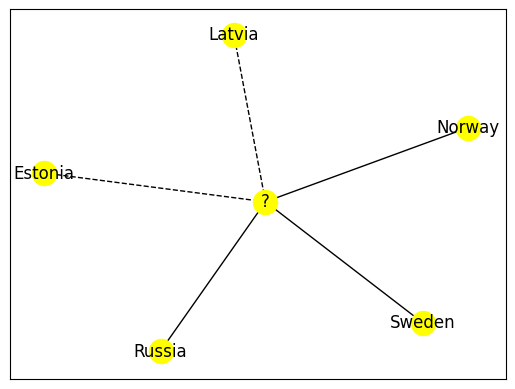

Guess the country by its neighbors. If you are tired enter `end`
Finland
Correct!



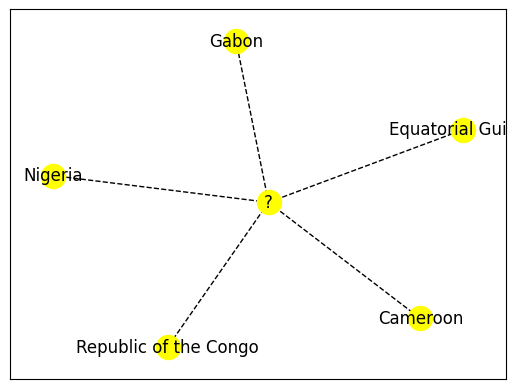

Guess the country by its neighbors. If you are tired enter `end`
???
Wrong answer. Correct answer is São Tomé and Príncipe



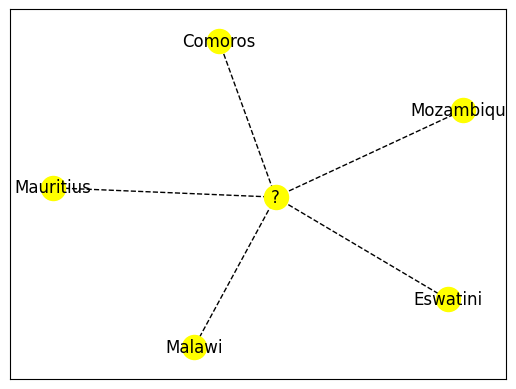

Guess the country by its neighbors. If you are tired enter `end`
Madagaskar
I think, you assumed Madagascar. I count that as a correct answer!



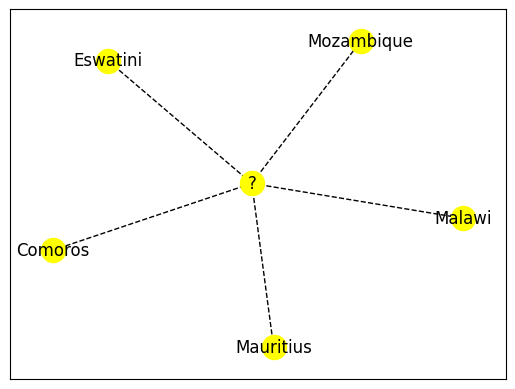

Guess the country by its neighbors. If you are tired enter `end`
again?
Wrong answer. Correct answer is Madagascar



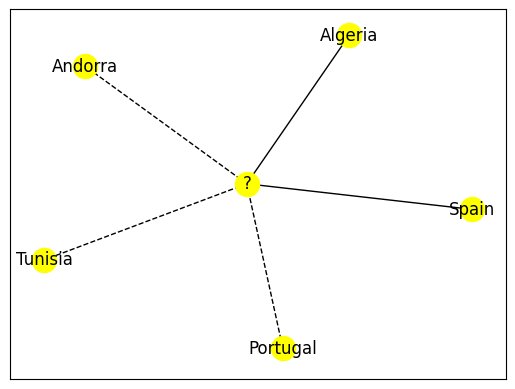

Guess the country by its neighbors. If you are tired enter `end`
Morocco
Correct!



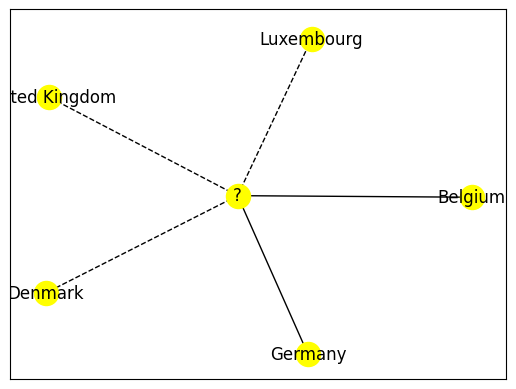

Guess the country by its neighbors. If you are tired enter `end`
Netherlands
Correct!



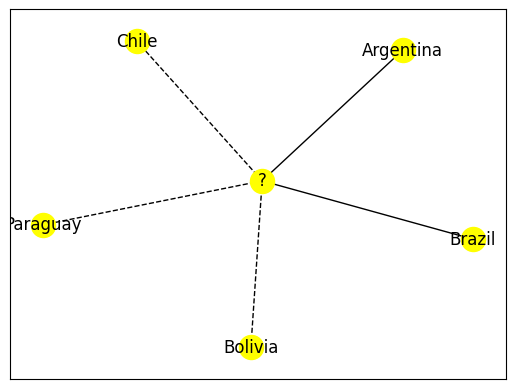

Guess the country by its neighbors. If you are tired enter `end`
Paraguay
Wrong answer. Correct answer is Uruguay



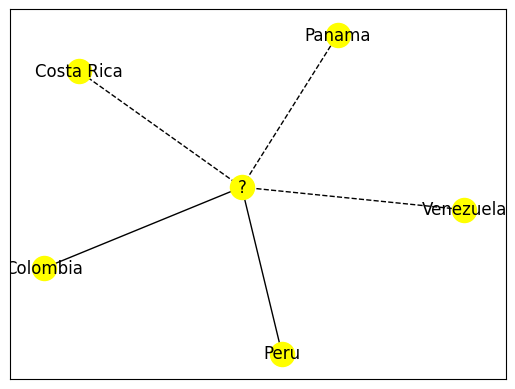

Guess the country by its neighbors. If you are tired enter `end`
end
You score is 4/7


In [ ]:
gm.country_border_test()

### Тест на знания флагов

Тут всё просто: нужно назвать страну по её флагу.

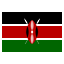

Guess the country by its flag. If you are tired enter `end`
Kenia
I think, you assumed Kenya. I count that as a correct answer!



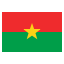

Guess the country by its flag. If you are tired enter `end`
Burkina-Faso
I think, you assumed Burkina Faso. I count that as a correct answer!



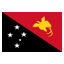

Guess the country by its flag. If you are tired enter `end`
Papua New Guinea
Correct!



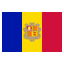

Guess the country by its flag. If you are tired enter `end`
Andorra
Correct!



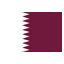

Guess the country by its flag. If you are tired enter `end`
Qatar
Correct!



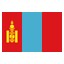

Guess the country by its flag. If you are tired enter `end`
Mongolia
Correct!



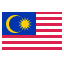

Guess the country by its flag. If you are tired enter `end`
Malasia
I think, you assumed Malaysia. I count that as a correct answer!



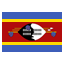

Guess the country by its flag. If you are tired enter `end`
Eswatini
Correct!



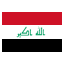

Guess the country by its flag. If you are tired enter `end`
Iraq
Correct!



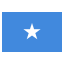

Guess the country by its flag. If you are tired enter `end`
Somalia
Correct!



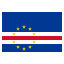

Guess the country by its flag. If you are tired enter `end`
Cape Verde
Correct!



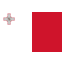

Guess the country by its flag. If you are tired enter `end`
Malta
Correct!



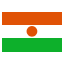

Guess the country by its flag. If you are tired enter `end`
Niger
Correct!



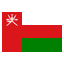

Guess the country by its flag. If you are tired enter `end`
Oman
Correct!



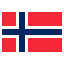

Guess the country by its flag. If you are tired enter `end`
norway
I think, you assumed Norway. I count that as a correct answer!



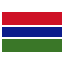

Guess the country by its flag. If you are tired enter `end`
Gambia
Correct!



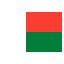

Guess the country by its flag. If you are tired enter `end`
Benin
Wrong answer. Correct answer is Madagascar



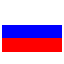

Guess the country by its flag. If you are tired enter `end`
Russia!!
I think, you assumed Russia. I count that as a correct answer!



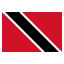

Guess the country by its flag. If you are tired enter `end`
Trinidad and Tobago
Correct!



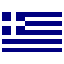

Guess the country by its flag. If you are tired enter `end`
end
You score is 18/19


In [ ]:
gm.country_flag_test()

### Тесты на столицы

В следующих двух тестах нужно назвать столицу страны и страну по её столице

In [ ]:
gm.country_capital_test()

Guess the country by its capital: Kuala Lumpur. If you are tired enter `end`
Malaysia
Correct!

Guess the country by its capital: Santo Domingo. If you are tired enter `end`
Dominica
Wrong answer. Correct answer is Dominican Republic

Guess the country by its capital: Ulan Bator. If you are tired enter `end`
Mongolia
Correct!

Guess the country by its capital: Porto-Novo. If you are tired enter `end`
Benin
Correct!

Guess the country by its capital: Lisbon. If you are tired enter `end`
Prtugal
I think, you assumed Portugal. I count that as a correct answer!

Guess the country by its capital: Dhaka. If you are tired enter `end`
Qatar
Wrong answer. Correct answer is Bangladesh

Guess the country by its capital: Ulan Bator. If you are tired enter `end`
end
You score is 4/6


In [ ]:
gm.capital_country_test()

Guess the capital of Saint Vincent and the Grenadines. If you are tired enter `end`
wtf
Wrong answer. Correct answer is Kingstown

Guess the capital of Gambia. If you are tired enter `end`
maybe easy questions???
Wrong answer. Correct answer is Banjul

Guess the capital of Russia. If you are tired enter `end`
Moscow!
I think, you assumed Moscow. I count that as a correct answer!

Guess the capital of Brazil. If you are tired enter `end`
Brasilia
I think, you assumed Brasília. I count that as a correct answer!

Guess the capital of Lithuania. If you are tired enter `end`
Vilnus
I think, you assumed Vilnius. I count that as a correct answer!

Guess the capital of Tuvalu. If you are tired enter `end`
Funafuti
Correct!

Guess the capital of Lesotho. If you are tired enter `end`
end
You score is 4/6


### Тест на расположение в мире

Здесь нужно назвать страну по её очертанию и очертанию соседних старн (если непонятно, то посмотрите примеры). Также будет показываться расположение столицы (жёлтая звёздочка). Страна, про которую спрашивают, выделена красным. Для упрощения показывается субрегион, в котором страна находится, а то не всегда сразу понятно, где это вообще находится.

Из-за того, что некоторые страны расположены рядом с 180 меридианом, при демонстрации картинка была сильно вытянута, и ничего нельзя было рассмотреть. Во избежание таких ситуаций не будут показываться страны Океании.

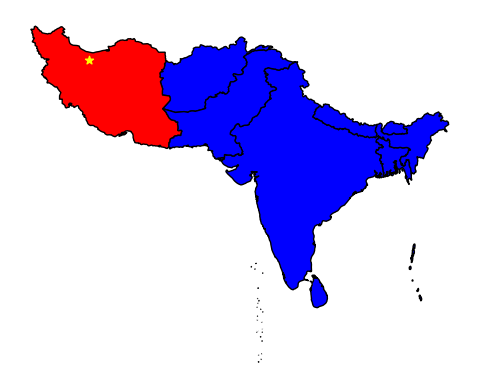

Guess the country by its location (subregion - Southern Asia). If you are tired enter `end`
Iran
Correct!



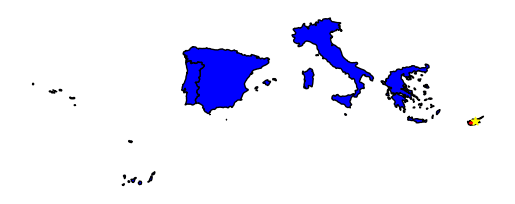

Guess the country by its location (subregion - Southern Europe). If you are tired enter `end`
Malta
Wrong answer. Correct answer is Cyprus



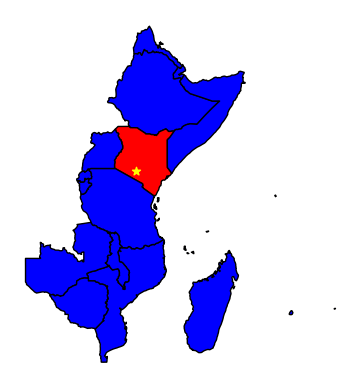

Guess the country by its location (subregion - Eastern Africa). If you are tired enter `end`
Kenya
Correct!



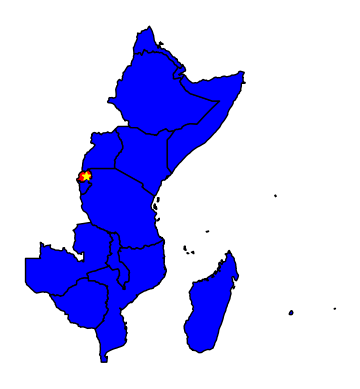

Guess the country by its location (subregion - Eastern Africa). If you are tired enter `end`
Liberia
Wrong answer. Correct answer is Rwanda



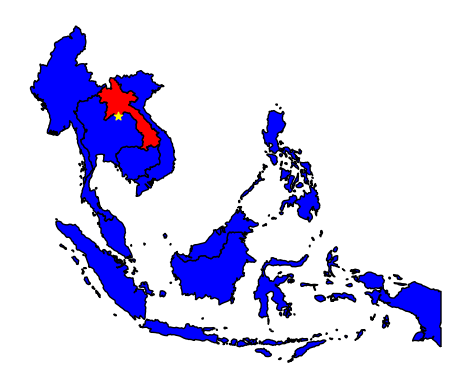

Guess the country by its location (subregion - South-Eastern Asia). If you are tired enter `end`
Laos
Correct!



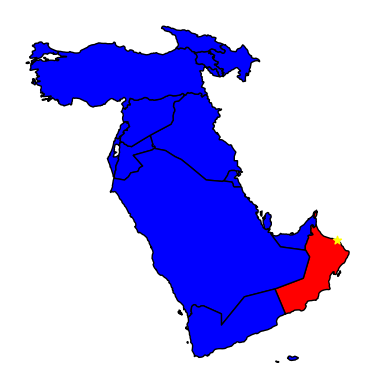

Guess the country by its location (subregion - Western Asia). If you are tired enter `end`
Oman
Correct!



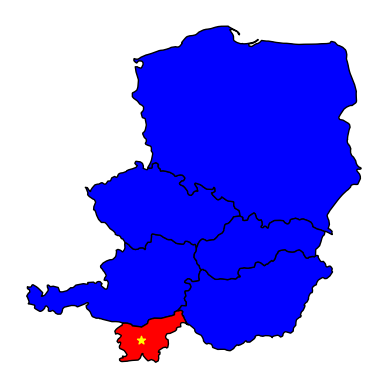

Guess the country by its location (subregion - Central Europe). If you are tired enter `end`
Swizerland
Wrong answer. Correct answer is Slovenia



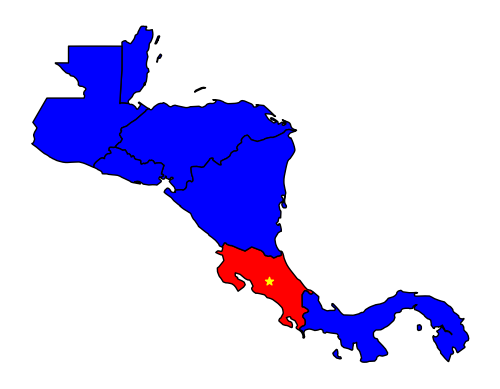

Guess the country by its location (subregion - Central America). If you are tired enter `end`
Nicaragua
Wrong answer. Correct answer is Costa Rica



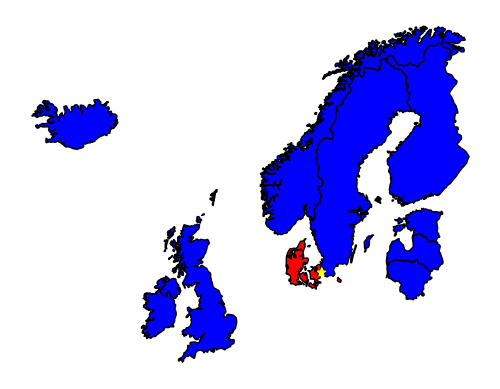

Guess the country by its location (subregion - Northern Europe). If you are tired enter `end`
Denmark
Correct!



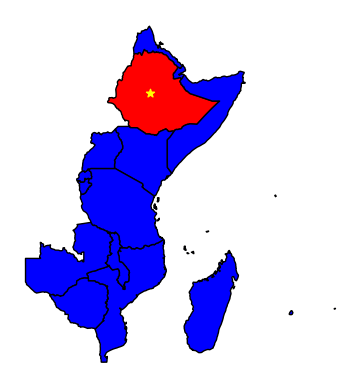

Guess the country by its location (subregion - Eastern Africa). If you are tired enter `end`
Ethiopia
Correct!



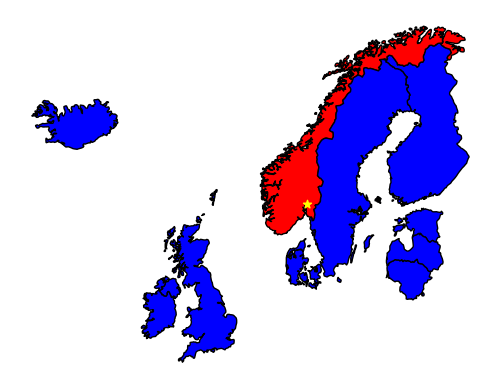

Guess the country by its location (subregion - Northern Europe). If you are tired enter `end`
noway
I think, you assumed Norway. I count that as a correct answer!



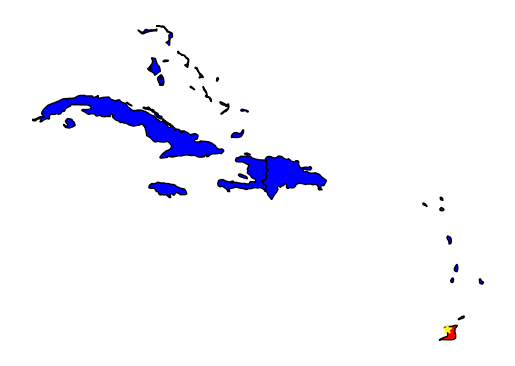

Guess the country by its location (subregion - Caribbean). If you are tired enter `end`
???
Wrong answer. Correct answer is Trinidad and Tobago



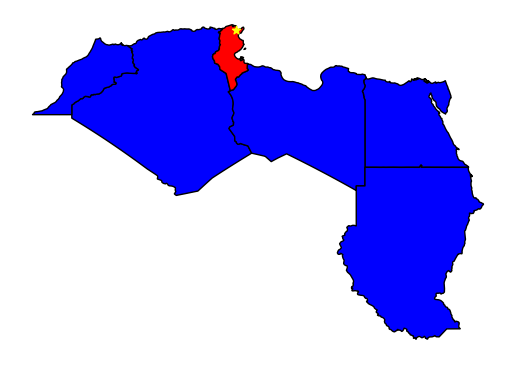

Guess the country by its location (subregion - Northern Africa). If you are tired enter `end`
Tunis
I think, you assumed Tunisia. I count that as a correct answer!



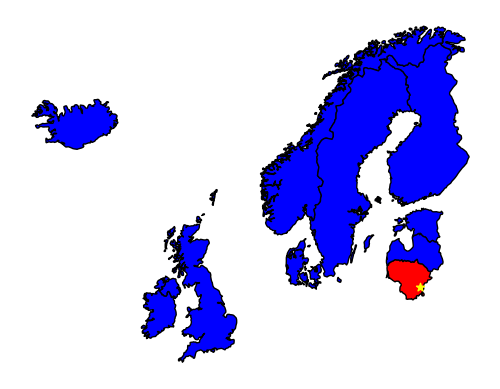

Guess the country by its location (subregion - Northern Europe). If you are tired enter `end`
end
You score is 8/13


In [ ]:
gm.country_location_test()

### Просмотр информации

Есть также возможность посмотреть информацию про страну. Отображается карта, на которой жёлтым цветом указана страна, а фиолетовым - её непосредственные соседи. При наведении на контур появляется вся информация про старну.

In [ ]:
gm.get_info('Hungary')

## Часть 3. Теперь ваша очередь

In [ ]:
# здесь ваш код
# (ﾉ◕ヮ◕)ﾉ*:・ﾟ✧